# 1.Preprocessing

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
df=pd.read_csv('./Data/data_9_5day.csv')

In [4]:
from sklearn.utils import shuffle
df = shuffle(df).reset_index(drop=True)

In [5]:
df.head()

,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Timestamp,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Fwd.Packet.Length.Max,...,min_seg_size_forward,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,ProtocolName
0,180881369,47126,3003188461,443,6,1.494323e+09,33970783,13,8,517,...,32,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,GOOGLE
1,3232253999,52539,180881158,3128,6,1.494318e+09,7113423,13,11,1418,...,20,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,GOOGLE
2,3232261637,49543,180881157,3128,6,1.494314e+09,114364374,145,173,220,...,20,5.093378e+06,7.418616e+06,18077732.0,209313.0,1.237077e+07,3.847733e+06,16359072.0,6443215.0,HTTP_PROXY
3,3232254071,1917,180881156,3128,6,1.494322e+09,3977362,2,0,6,...,20,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,HTTP_CONNECT
4,180881160,3128,3232273938,54107,6,1.494322e+09,114225707,91,38,1427,...,20,2.955797e+05,2.659303e+05,652026.0,64467.0,1.868151e+07,1.028667e+07,28859303.0,5083478.0,HTTP_PROXY


In [6]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]
XU_train,XL,yu_train,yL=train_test_split(X,y,random_state=0,test_size=0.7)# labeled unlabeled split

In [7]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 

Using TensorFlow backend.


In [8]:
XL['ProtocolName']=yL
a=XL.groupby('ProtocolName')['ProtocolName'].count().sort_values(ascending=False)


c:\users\dhruvjyoti\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
#oversample
b=a.where(a>3000)
b=b.fillna(3000,downcast='infer')
threshold=dict(zip(b.index,b.values))
ros=RandomOverSampler(sampling_strategy=threshold,random_state=0)
Xi=XL.iloc[:,:-1]
yi=yL
X1,y1=ros.fit_resample(Xi,yi)
#undersample
b=b.where(b<4000)
b=b.fillna(4000,downcast='infer')
threshold=dict(zip(b.index,b.values))
rus=RandomUnderSampler(sampling_strategy=threshold,random_state=0)

XL_train,yL_train=rus.fit_resample(X1,y1)

In [10]:
'''
Function mask_noise

Input: numpy array , fraction_delete(between 0 and 1)

Removes a fraction_delete fraction of the input array X randomly

Output: numpy array after deletions

'''
def mask_noise(X,fraction_delete=0.2):
    mask=np.random.rand(np.shape(X)[0],np.shape(X)[1])
    mask=1*(mask>fraction_delete)
    return mask*X

In [11]:
from keras.layers import Input, Dense
from keras.models import Model
import keras.backend as K
import tensorflow as tf

In [12]:
'''
Sparcity Autoencoder's Sparcity Activity Regularization

'''
def kl_divergence(rho, rho_hat):
    return rho * tf.math.log(rho) - rho * tf.math.log(rho_hat+1e-12) + (1 - rho) * tf.math.log(1 - rho) - (1 - rho) * tf.math.log(1 - rho_hat+1e-12)

class SparseActivityRegularizer(tf.keras.regularizers.Regularizer):

    def __init__(self, p=0.1, sparsityBeta=3):
        self.p = p
        self.sparsityBeta = sparsityBeta

    def __call__(self, x):
        regularization = 0            

        p_hat = K.mean(x, axis=0)
        regularization += self.sparsityBeta * K.sum(kl_divergence(self.p, p_hat))

        return regularization

    def get_config(self):
        return {"name": self.__class__.__name__} 

In [13]:
from keras.layers import BatchNormalization
from keras.optimizers import RMSprop
from keras.optimizers import Adam

In [14]:
#X=df.iloc[:,:-1]
#y=df.iloc[:,-1]
yL_train=pd.get_dummies(yL_train)#One-hotencoding

# Split into train,test and val

XL_train,XL_val,yL_train,yL_val=train_test_split(XL_train,yL_train,random_state=0,test_size=0.2)
#print(len(X_val))
XL_val,XL_test,yL_val,yL_test=train_test_split(XL_val,yL_val,random_state=0,test_size=0.5)

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
#scaling and normalization
XU_train=scaler.fit_transform(XU_train)
XL_train=scaler.fit_transform(XL_train)
XL_val=scaler.transform(XL_val)
XL_test=scaler.transform(XL_test)

In [16]:
#XU_train,XL_train,yU_train,yL_train=train_test_split(X_train,y_train,random_state=0,test_size=0.5)

# 2. Training the SDAE

In [17]:
'''
Function SDAE
Inputs: numpy array X, list layers,list activations,float fraction_delete
layers is a list of no. of hidden nodes in each hidden layer
activations is a list of activations used in each encoding layer
trains each autoencoder layer and outputs all the encoder-layer models.
Output: a list of keras models

'''


def SDAE(X,layers,activations,fraction_delete=0.2):
    layers.insert(0,len(X[0]))
    #layers.insert(0,len(X_train.iloc[0]))
    ec=[]
    for i in range(len(layers)-1):
        encoding_dim = layers[i+1]

    # this is our input placeholder
        input_ = Input(shape=(layers[i],))
    # define regulariser
        regulariser = SparseActivityRegularizer(0.1, 3)
        
        #bn=BatchNormalization()(input_)

    # "encoded" is the encoded representation of the input
        encoded = Dense(encoding_dim, activation=activations[i],activity_regularizer=regulariser)(input_)
    # "decoded" is the lossy reconstruction of the input
        decoded = Dense(layers[i],activation=None)(encoded)
        #bn2 = BatchNormalization()(decoded)

    # this model maps an input to its reconstruction
        autoencoder = Model(input_, decoded)

    # this model maps an input to its encoded representation
        encoder = Model(input_, encoded)

    # create a placeholder for an encoded (32-dimensional) input
        encoded_input = Input(shape=(encoding_dim,))

        autoencoder.compile(optimizer=RMSprop(learning_rate=0.001,clipnorm=5), loss='mean_squared_error')
        X_noisy=mask_noise(X,fraction_delete)
        print('Training Layer ' + str(i+1)+' : ')
        autoencoder.fit(X_noisy, X,
                epochs=10,
                batch_size=128,
                shuffle=True)
        ec.append(encoder)
        X=encoder.predict(X)
    print('All Layers Done!')    
    return ec        

In [18]:
#XU_train,XL_train,yU_train,yL_train=train_test_split(X_train,y_train,random_state=0,test_size=0.5)
#train Sparse Stacked Denoising Autoencoder
layers = [50,50]
activations=['relu','relu']
stacked_layers=SDAE(XU_train,layers,activations)

Training Layer 1 : 
Epoch 1/10
121358/121358 [==============================] - 2s 16us/step - loss: 1.5314
Epoch 2/10
121358/121358 [==============================] - 2s 14us/step - loss: 0.6530
Epoch 3/10
121358/121358 [==============================] - 1s 12us/step - loss: 0.5635
Epoch 4/10
121358/121358 [==============================] - 1s 12us/step - loss: 0.5027
Epoch 5/10
121358/121358 [==============================] - 1s 12us/step - loss: 0.4476
Epoch 6/10
121358/121358 [==============================] - 1s 12us/step - loss: 0.4034
Epoch 7/10
121358/121358 [==============================] - 1s 12us/step - loss: 0.3691
Epoch 8/10
121358/121358 [==============================] - 1s 12us/step - loss: 0.3370
Epoch 9/10
121358/121358 [==============================] - 2s 13us/step - loss: 0.3122
Epoch 10/10
121358/121358 [==============================] - 1s 12us/step - loss: 0.2892
Training Layer 2 : 
Epoch 1/10
121358/121358 [==============================] - 1s 10us/step - loss

# 3.Training the SoftMax classifier

In [19]:
'''
Performs a Forward Pass through the SDAE

'''
def SDAE_predict(stacked_layers,X):
    for layer in stacked_layers:
        X1=layer.predict(X)
        X=X1
    return X1    

In [20]:
#forward pass through SDAE
XL_train1=SDAE_predict(stacked_layers,XL_train)
XL_val1=SDAE_predict(stacked_layers,XL_val)

In [21]:
from tensorflow.keras import regularizers

In [22]:
#Train Classifier separately
input1 = Input(shape=(layers[-1],))
bn1=BatchNormalization()(input1)
#L0 = Dense(100,activation='tanh')(bn1) #if one wishes to include another layer, just uncomment
L1 = Dense(len(yL_train.columns),activation='softmax',kernel_regularizer=regularizers.l2(0.0001) )(bn1)
classifier=Model(input1,L1)
classifier.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
classifier.fit(XL_train1,yL_train,
                epochs=40,
                batch_size=64,
                shuffle=True,
                validation_data=(XL_val1, yL_val))

Train on 131546 samples, validate on 16443 samples
Epoch 1/40
131546/131546 [==============================] - 3s 21us/step - loss: 2.3818 - accuracy: 0.4191 - val_loss: 1.9706 - val_accuracy: 0.4960
Epoch 2/40
131546/131546 [==============================] - 3s 21us/step - loss: 1.9281 - accuracy: 0.5005 - val_loss: 1.8533 - val_accuracy: 0.5212
Epoch 3/40
131546/131546 [==============================] - 3s 24us/step - loss: 1.8568 - accuracy: 0.5139 - val_loss: 1.8031 - val_accuracy: 0.5379
Epoch 4/40
131546/131546 [==============================] - 3s 20us/step - loss: 1.8241 - accuracy: 0.5229 - val_loss: 1.7728 - val_accuracy: 0.5464
Epoch 5/40
131546/131546 [==============================] - 3s 20us/step - loss: 1.8090 - accuracy: 0.5272 - val_loss: 1.7580 - val_accuracy: 0.5494
Epoch 6/40
131546/131546 [==============================] - 3s 19us/step - loss: 1.7971 - accuracy: 0.5321 - val_loss: 1.7545 - val_accuracy: 0.5476
Epoch 7/40
131546/131546 [=============================

# 4. Fine Tuning

In [23]:
from tensorflow.keras import regularizers
from keras.models import load_model

In [24]:
# change regularisation settings
a=[]
input2=Input(shape=(len(XL_train[0]),))
a.append(input2)
for i in range(len(stacked_layers)):
    print(stacked_layers[i](a[i]))
    encoder=stacked_layers[i]
    encoder.layers[-1].kernel_regularizer=regularizers.l2(0.0001) #set or reset weight regularizer 
    encoder.layers[-1].activity_regularizer=None #remove Sparse activity regularizer
    encoder.save('temp.h5')
    encoder=load_model('temp.h5')
    print(encoder.losses)
    a.append(encoder(a[i]))
classifier.layers[-1].kernel_regularizer=regularizers.l2(0.0001)#set or reset weight regularizer 
classifier.save('temp.h5')
classifier=load_model('temp.h5')
print(classifier.losses)
a.append(classifier(a[-1]))    

Tensor("model_2/dense_1/Relu:0", shape=(None, 50), dtype=float32)
[<tf.Tensor 'dense_1_1/weight_regularizer/add:0' shape=() dtype=float32>]
Tensor("model_4/dense_3/Relu:0", shape=(None, 50), dtype=float32)
[<tf.Tensor 'dense_3_1/weight_regularizer/add:0' shape=() dtype=float32>]


c:\users\dhruvjyoti\appdata\local\programs\python\python37\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[<tf.Tensor 'dense_5_1/weight_regularizer/add:0' shape=() dtype=float32>]


In [25]:
model=Model(input2,a[-1])#final fine tuned model

In [26]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [27]:
#fine tune
model.fit(XL_train,yL_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(XL_val, yL_val))

Train on 131546 samples, validate on 16443 samples
Epoch 1/50
131546/131546 [==============================] - 2s 12us/step - loss: 1.9004 - accuracy: 0.5669 - val_loss: 1.8611 - val_accuracy: 0.5728
Epoch 2/50
131546/131546 [==============================] - 1s 11us/step - loss: 1.6892 - accuracy: 0.6152 - val_loss: 1.7495 - val_accuracy: 0.5972
Epoch 3/50
131546/131546 [==============================] - 1s 11us/step - loss: 1.5866 - accuracy: 0.6387 - val_loss: 1.5829 - val_accuracy: 0.6395
Epoch 4/50
131546/131546 [==============================] - 2s 12us/step - loss: 1.5140 - accuracy: 0.6567 - val_loss: 1.5211 - val_accuracy: 0.6472
Epoch 5/50
131546/131546 [==============================] - 1s 11us/step - loss: 1.4566 - accuracy: 0.6677 - val_loss: 1.5677 - val_accuracy: 0.6414
Epoch 6/50
131546/131546 [==============================] - 2s 11us/step - loss: 1.4113 - accuracy: 0.6786 - val_loss: 1.4556 - val_accuracy: 0.6627
Epoch 7/50
131546/131546 [=============================

# 5. Results

In [28]:
y_pred=model.predict(XL_test)
y_pred

array([[1.78892712e-09, 6.48167848e-12, 7.75055076e-10, ...,
        2.32765340e-09, 2.32134227e-07, 1.03883202e-07],
       [4.23985557e-06, 1.38816079e-08, 4.24314184e-09, ...,
        3.04522746e-06, 2.20475886e-05, 5.69362019e-04],
       [1.51185282e-02, 1.16384726e-04, 5.50670266e-05, ...,
        3.78914028e-02, 4.86062914e-02, 1.18606212e-02],
       ...,
       [3.14814663e-08, 3.76504577e-05, 4.39647696e-09, ...,
        3.19572426e-02, 5.49352137e-07, 1.00038135e-02],
       [6.27197907e-04, 1.58488483e-03, 4.83004925e-08, ...,
        1.16681054e-04, 7.53008237e-07, 5.42599191e-05],
       [1.61502423e-04, 1.54664530e-08, 1.01122730e-13, ...,
        1.90077626e-04, 3.18546663e-04, 2.96439953e-06]], dtype=float32)

In [29]:
y_pred1=y_pred.argmax(axis=1)
y_pred1=pd.get_dummies(y_pred1)
y_pred1.columns=yL_test.columns

In [30]:
y_test1 = yL_test.columns[np.where(yL_test!=0)[1]]

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [32]:
len(y_pred1)

16444

In [33]:
y_pred1=y_pred1.columns[np.where(y_pred1!=0)[1]]
y_pred1

Index(['RTMP', 'SIMET', 'NETFLIX', 'AMAZON', 'MICROSOFT', 'APPLE_ITUNES',
       'WHATSAPP', 'CLOUDFLARE', 'TEAMVIEWER', 'UBUNTUONE',
       ...
       'NTP', 'SSL', 'TEAMVIEWER', 'STARCRAFT', 'CONTENT_FLASH', 'H323',
       'MQTT', 'WHATSAPP', 'OFFICE_365', 'HTTP_DOWNLOAD'],
      dtype='object', length=16444)

In [34]:
cm=confusion_matrix(y_test1,y_pred1,labels=yL_test.columns)

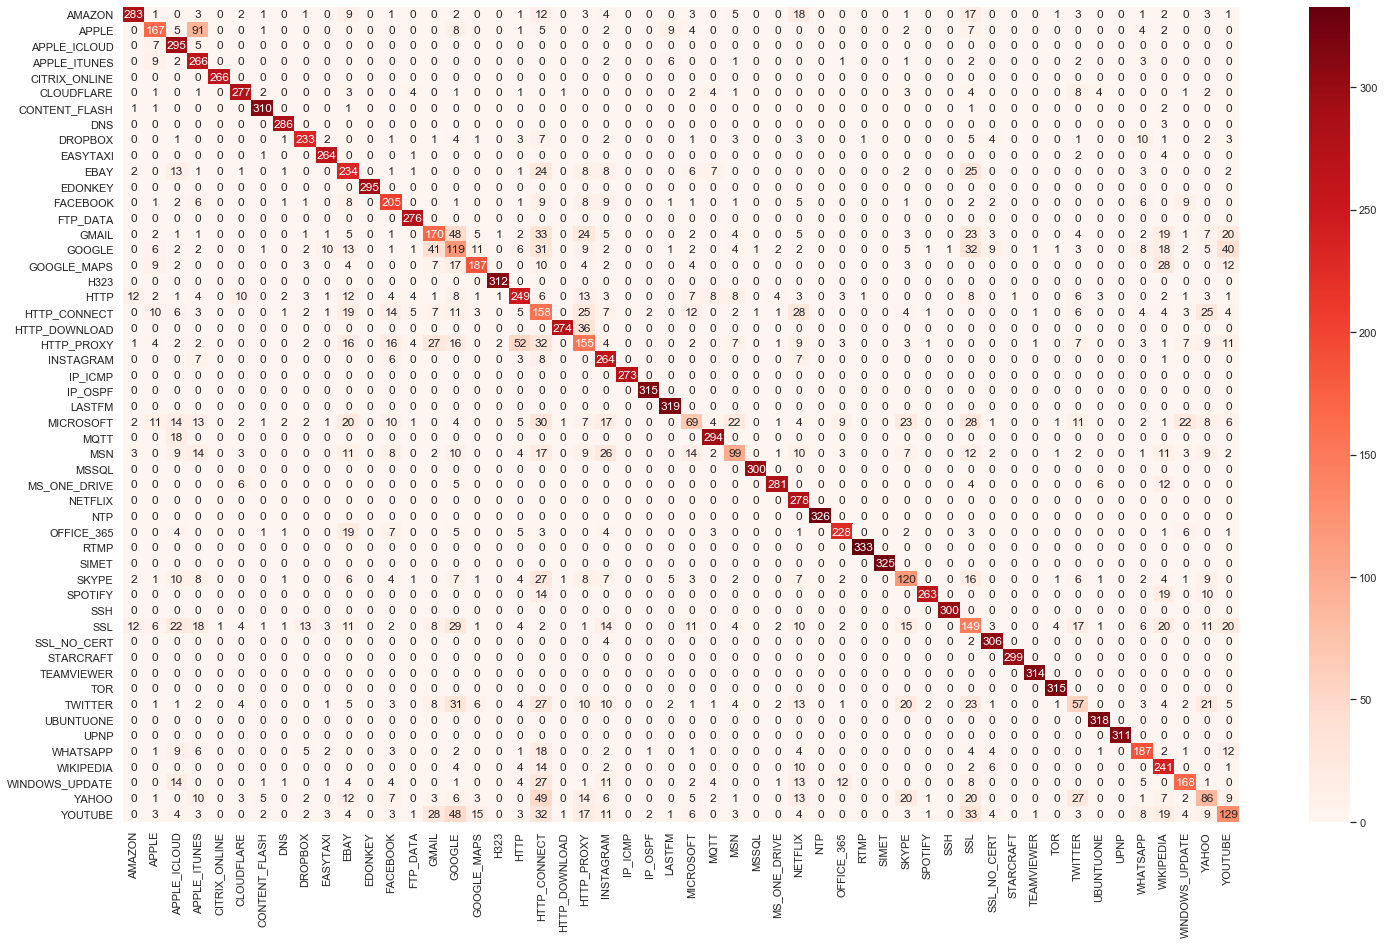

In [35]:
plt.figure(figsize=(25,15))
df_cm=pd.DataFrame(cm,columns=yL_test.columns,index=yL_test.columns)
sns.set(font_scale=1.0)
sns.heatmap(df_cm, annot=True,fmt='d',cmap=plt.cm.get_cmap('Reds')) # font size
plt.show()

In [36]:
print('weighted F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'weighted')))
print('Macro F1 Score : ' + str(f1_score(y_pred1,y_test1,average = 'macro')))
print('F1 Scores : ' )
pd.DataFrame(f1_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['F1-score'],index=yL_test.columns)

weighted F1 Score : 0.7705756343365969
Macro F1 Score : 0.7693694115104794
F1 Scores : 


,F1-score
AMAZON,0.813218
APPLE,0.605072
APPLE_ICLOUD,0.793011
APPLE_ITUNES,0.699080
CITRIX_ONLINE,0.998124
CLOUDFLARE,0.876582
CONTENT_FLASH,0.964230
DNS,0.974446
DROPBOX,0.829181
EASYTAXI,0.939502


In [37]:
len(yL_train.columns)# No. of distinct labels

52

In [50]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [49]:
print('Macro Presicion : '+str(precision_score(y_test1, y_pred1,average="macro")))
print('Weighted Presicion : '+str(precision_score(y_test1, y_pred1,average="weighted")))
print('Precision Scores : ' )
pd.DataFrame(precision_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['Precision-score'],index=yL_test.columns)

Macro Presicion : 0.7741715164289672
Weighted Presicion : 0.7620908813466739
Precision Scores : 


,Precision-score
AMAZON,0.748677
APPLE,0.542208
APPLE_ICLOUD,0.960912
APPLE_ITUNES,0.901695
CITRIX_ONLINE,1.000000
CLOUDFLARE,0.865625
CONTENT_FLASH,0.981013
DNS,0.989619
DROPBOX,0.803448
EASYTAXI,0.970588


In [51]:
print('Macro Recall : '+str(recall_score(y_test1, y_pred1,average="macro")))
print('Weighted Recall : '+str(recall_score(y_test1, y_pred1,average="weighted")))
print('Recall Scores : ' )
pd.DataFrame(recall_score(y_pred1,y_test1,labels=yL_test.columns,average = None),columns=['recall-score'],index=yL_test.columns)

Macro Recall : 0.7786865789893403
Weighted Recall : 0.7630746776939917
Recall Scores : 


,recall-score
AMAZON,0.889937
APPLE,0.684426
APPLE_ICLOUD,0.675057
APPLE_ITUNES,0.570815
CITRIX_ONLINE,0.996255
CLOUDFLARE,0.887821
CONTENT_FLASH,0.948012
DNS,0.959732
DROPBOX,0.856618
EASYTAXI,0.910345
